In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


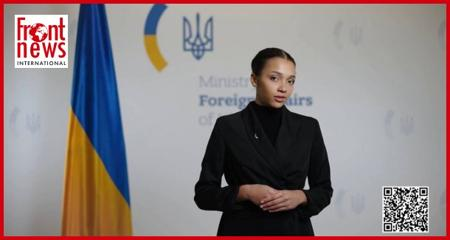

[Ukraine adds an AI avatar spokesperson.](https://frontnews.eu/en/news/details/78974)

___

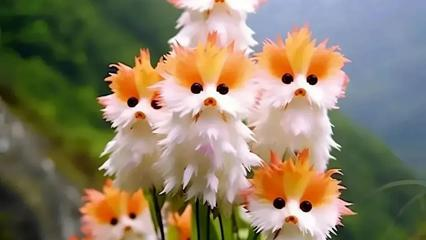

[Scammers sell products that exist only in AI's hallucinatory imagination.](https://www.odditycentral.com/news/people-are-getting-scammed-into-buying-seeds-of-non-existent-cat-face-flowers-generated-by-ai.html) - Oddity Central - Collecting Oddities

___

[Upwork adds AI to better match remote workers and employers.](https://www.fastcompany.com/91114117/upwork-ai-platform-uma)

___

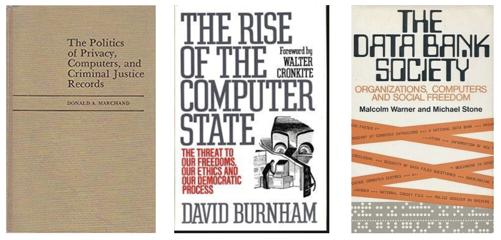

[AI makes many artisanal bespoke tasks amenable to mass production.](https://www.ben-evans.com/benedictevans/2024/4/29/problems-of-scale-z7mrb) - Benedict Evans

___

Time for a Turing Test game show - AI or not AI? To Tell the Truth, but you have to tell which member of the panel is AI.

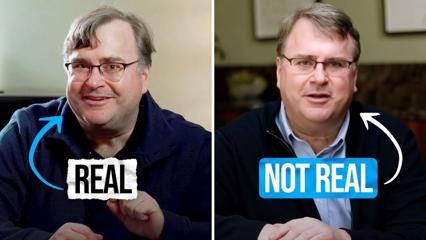

[Reid Hoffman's digital AI twin.](https://www.youtube.com/watch?v=rgD2gmwCS10) - YouTube

___

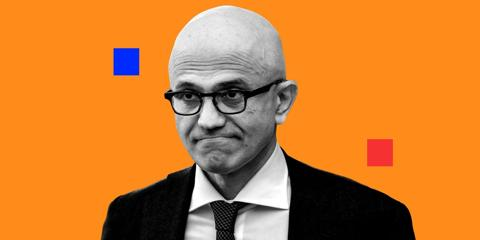

[2019 email from Kevin Scott to Satya Nadella said he was 'very worried' that they were 'multiple years behind'](https://www.businessinsider.com/satya-nadella-bill-gates-microsoft-concern-google-rivals-ai-emails-2024-5) - Business Insider

___

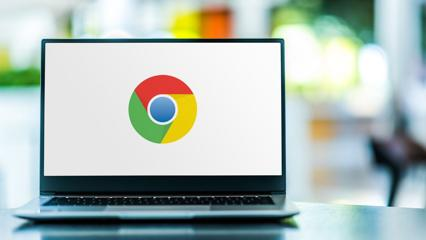

[Coming soon: summon Gemini with an @ in the Chrome search bar.](https://www.tomsguide.com/ai/google-gemini/google-chrome-users-will-soon-be-able-to-access-gemini-ai-directly-from-the-search-bar-heres-how) - Tom's Guide

___

[Rumors of an OpenAI announcement on May 9 with a Perplexity competitor.](https://twitter.com/apples_jimmy/status/1785436609095328067)

___

[AI probably increases income inequality but then so would 'living wage' laws.](https://www.latimes.com/opinion/story/2024-05-01/ai-automation-fast-food-minimum-wage-california-restaurants-corporations)

___

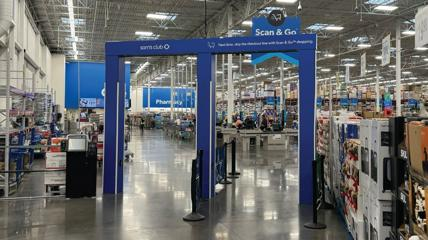

[Sam's Club installs AI-powered exit checks in 20% of warehouse stores.](https://techcrunch.com/2024/04/30/sams-clubs-ai-powered-exit-tech-reaches-20-of-stores/) - TechCrunch

___

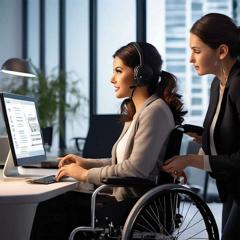

[AI assistance is a huge benefit to the elderly and disabled.](https://www.pcquest.com/tech-trends/how-ai-is-revolutionizing-assistive-technology-4523504) - PCQ

___

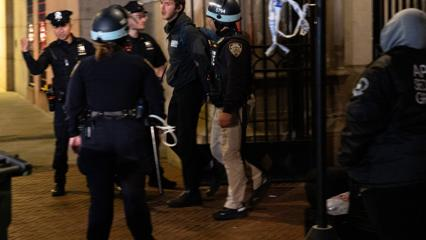

[Ah yes, the infamous 'outside agitators'. Useful idiot for dumbass trustees and donors, they aren't standing by her, or students or faculty. Out within a year or sooner.](https://www.nbcnewyork.com/news/local/read-the-letter-columbia-universitys-president-sent-to-the-nypd-asking-for-assistance/5370439/) - NBC New York

___

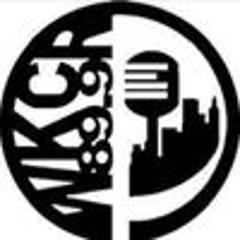

['flooding the building from all sides', climbing in via ladders, unconscious student in front of hamilton, protesters removed from front of hamilton, smell of teargas, kcr website may have crashed www.instagram.com/wkcr/](https://www.instagram.com/wkcr/)

___

cops using lifts, sledgehammers to enter Hamilton Hall, escorting all the student press out of the area and off campus

NYPD used bullhorns to tell Hamilton Hall occupiers to disperse, a large number (like hundreds) surrounding encampment, marching to Hamilton Hall.

[You can listen to Columbia's student radio as it appears that NYPD is arriving in force with jail buses www.cc-seas.columbia.edu/wkcr/](https://www.cc-seas.columbia.edu/wkcr/)

___

[Google introduces a medical LLM based on Gemini it says is the new state of the art.](https://twitter.com/alan_karthi/status/1785117444383588823)

___

Suggests GPT-4.5 might be available soon, and maybe that it will be more of the same, possibly catch up to Gemini on multimodal and long context, and try to re-establish a clear lead for ChatGPT after Claude, Gemini caught up.

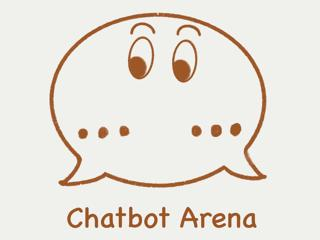

[gpt2-chatbot removed from LMSYS, seems plausible that OpenAI was doing anonymized head-to-head comparison testing with a new model, which was not supposed to be visible as a bot anyone could chat with.](https://lmsys.org/blog/2024-03-01-policy/)

___

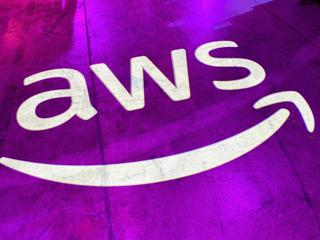

[Amazon's CodeWhisperer rebrands to Q Developer, adds full software development lifecycle stuff.](https://techcrunch.com/2024/04/30/amazon-codewhisperer-is-now-called-q-developer-and-is-expanding-its-functions/) - TechCrunch

___

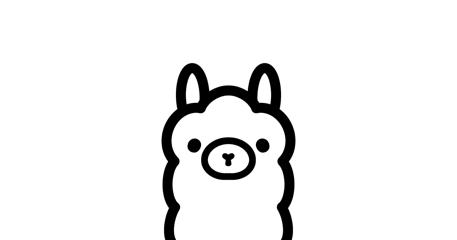

[Llama variant extends context window to over 1m tokens. No metrics on how well it can cherry-pick what it needs from within that context window.](https://ollama.com/library/llama3-gradient)

___

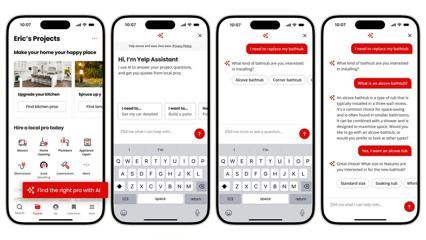

[Yelp has a new home repair AI bot that will quiz you on your needs.](https://www.cnet.com/tech/services-and-software/yelp-has-a-new-ai-bot-for-home-repairs-and-itll-quiz-you-on-your-needs/) - CNET

___

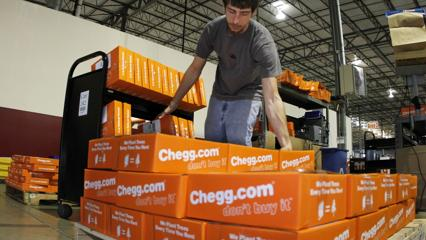

[Chegg and Coursera get taken down a notch by ChatGPT.](https://www.cnbc.com/2024/04/30/online-education-stocks-tank-on-chatgpt-threat.html) - CNBC

___

[Jailbreaking AI to make it talk dirt to you.](https://www.wsj.com/lifestyle/chatgpt-ai-boyfriend-spicy-8ac6a6e9)

___

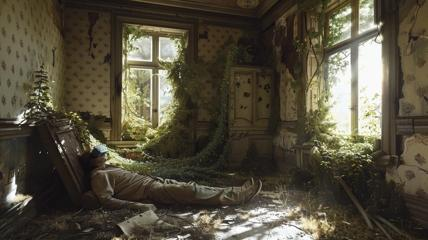

[Data artist Robert Hodgin created a recursive feedback loop between Midjourney and ChatGPT-4: “the former creates an image from a description and the latter creates a description from an image”. [kottke.org]](https://kottke.org/24/04/ai-image-feedback-loop) - kottke.org

___

[Sam Altman comments cryptically](https://twitter.com/sama/status/1785107943664566556)

___

Low-power embedded systems are also critical for self-driving and Mercedes is an investor, also e.g. drones.

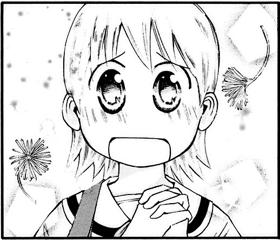

[More discussion of gpt2-chatbot and why people think it's an OpenAI test of GPT 4.5 or something.](https://rentry.co/GPT2)

___

[Some thoughts on the mysterious gpt2-chatbot, seems to bear hallmarks of an OpenAI product, but not a big leap over GPT-4](https://twitter.com/simonw/status/1784996728552427726)

___

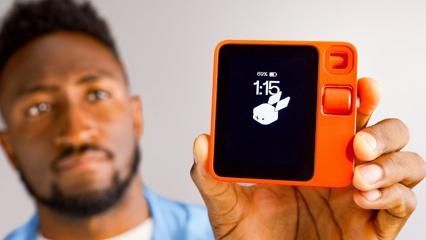

[MKBHD says the Rabbit R1 might stretch the definition of 'minimum' in 'minimum viable product' beyond viability, which is consistent with what others have said, fun and promising but not quite ready for prime time.](https://www.youtube.com/watch?v=ddTV12hErTc) - YouTube

___

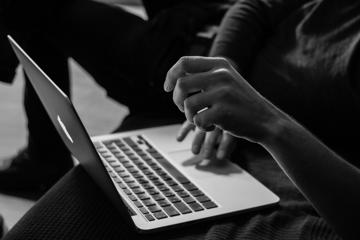

[AI writing tools tout how undetectable they are.](https://www.cultofmac.com/853153/10-best-undetectable-ai-tools-for-bypassing-ai-detection/) - Cult of Mac

___

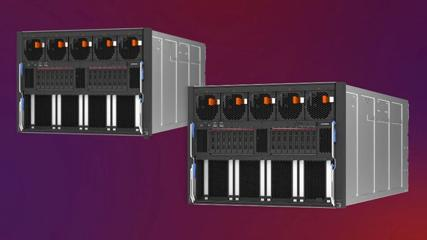

[A nice Lenovo box to run your AI training or inference on, with probably 256 CPU cores and 8 MI300X or H200 GPUs. Guessing like \\$200K for the AMD version, if you have to ask the price of the Nvidia version you can't afford it.](https://www.techradar.com/pro/lenovo-unveils-first-all-amd-ai-supercomputer-flanked-with-up-to-15tb-of-hbm-memory-and-promises-drop-in-support-for-the-future-amd-epyc-cpu-new-thinksystem-has-dual-epyc-cpus-and-8-instinct-mi300x-gpus) - TechRadar

___

[Is it unethical to write articles on bypassing GPTzero AI detection, like teaching kids to cheat or hack or something?](https://medium.com/@aiuniverse/how-to-bypass-gptzero-ai-detection-2024-guide-95537d843220)

___

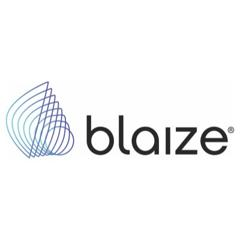

[Edge AI hardware company raises \\$106m. I think these might be the cards and embedded systems you could for instance put in cameras in a store for facial recognition, pose detection, analyzing foot traffic in real-time, do everything locally instead of sending video streams to the cloud.](https://www.finsmes.com/2024/04/blaize-raises-106m-in-funding.html) - FinSMEs

___

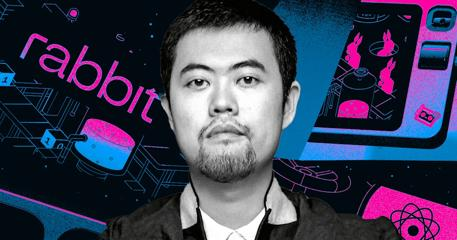

[A profile of Rabbit R1 creator Jesse Lyu.](https://www.inverse.com/tech/rabbit-r1-jesse-lyu-interview-artificial-intelligence) - Inverse

___

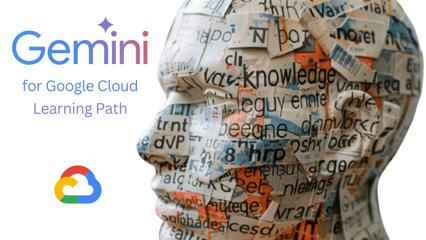

[Google releases courses on how engineers can use Gemini for data science, network / cloud architecture, security etc.](https://www.kdnuggets.com/free-google-cloud-learning-path-for-gemini) - KDnuggets

___

[Yelp creates AI-generated video restaurant profiles based on user reviews.](https://www.fastcompany.com/91114979/yelp-restaurant-review-videos-directed-ai)

___

[FT analysis of LinkedIn data says Google loses AI staff to Apple.](https://www.ft.com/content/87054a60-dc4d-4238-a4b9-93ab48f22f56)

___

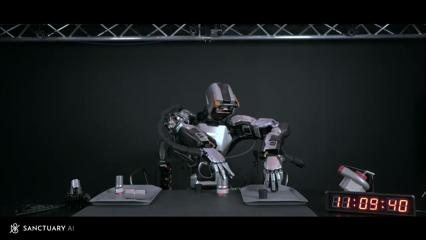

[Chinese humanoid robot looks smooth. Maybe a human controlling it, like Musk's robot demos, or a guy in a robot suit, or gen AI LOL?](https://www.youtube.com/watch?v=FH3zbUSMAAU) - YouTube

___

ChatGPT now has a 'dynamic' model selection option that will route to GPT-4 or lesser models based on the type of query.

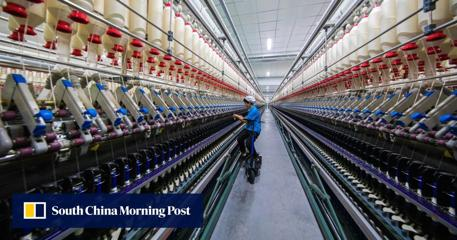

[Sanctions were put in place against Xinjiang force-labor practices, so factories automated with AI. Human rights win?](https://www.scmp.com/news/china/science/article/3260766/how-5g-ai-and-cotton-revolution-helped-china-beat-us-xinjiang-sanctions) - South China Morning Post

___

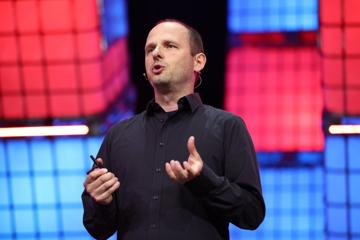

[Copilot Workspace is GitHub dipping a toe into AI-powered software engineering like Devin](https://techcrunch.com/2024/04/29/copilot-workspace-is-githubs-take-on-ai-powered-software-engineering/) - TechCrunch

___

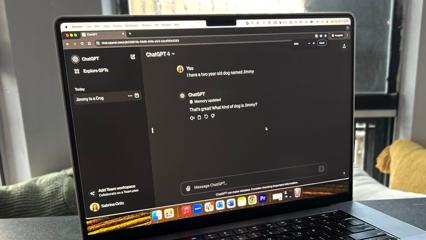

[ChatGPT 'memory' turned on for all Plus subscribers.](https://www.zdnet.com/article/openai-makes-memory-available-to-all-chatgpt-plus-subscribers-how-to-use-it/) - ZDNET

___

[AI Faces Its ‘Oppenheimer Moment’ Amid Killer Robot Arms Race](https://www.bloomberg.com/news/articles/2024-04-29/ai-faces-its-oppenheimer-moment-amid-killer-robot-arms-race)

___

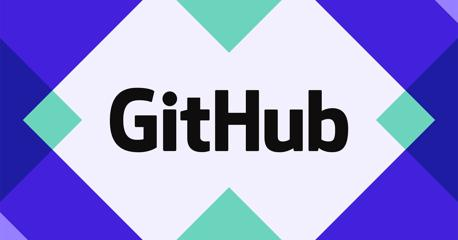

[GitHub Copilot will now architect greenfield projects, or something.](https://www.theverge.com/2024/4/29/24144454/github-copilot-workspace-ai-coding-developer-preview-launch) - The Verge

___

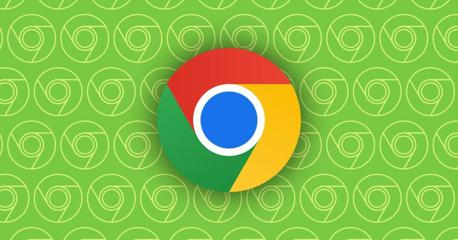

[Google updates Chrome address bar with AI.](https://9to5google.com/2024/04/29/chrome-address-bar-ml/) - 9to5Google

___

[There is a new chatbot called gpt2-chatbot available at chat.lmsys.org, not ranked yet but people are speculating someone is testing something pretty good.](https://news.ycombinator.com/item?id=40199715)

___

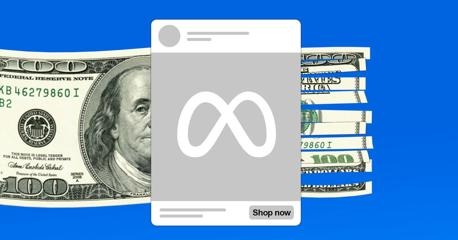

[Meta's AI ad platform is going off the rails.](https://www.theverge.com/2024/4/28/24141585/meta-ai-advantage-plus-automated-ad-glitch-cpm) - The Verge

___

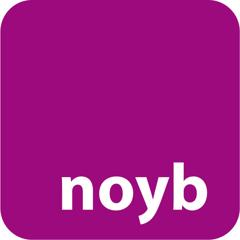

[ChatGPT is the subject of a GDPR complaint over hallucinating false statements about people.](https://noyb.eu/en/chatgpt-provides-false-information-about-people-and-openai-cant-correct-it) - noyb.eu

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [14]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 5, 1, 15, 1, 16, 802000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-04-30 05:01:48.581653
